<a href="https://colab.research.google.com/github/Vitaly-lv/DS2022/blob/main/HW_3_AE_LeontevVV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
dataset = datasets.MNIST('.', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



1. Обучить AE собственной архитектуры на MNIST

In [ ]:
# hyperparams
in_chan = 1
hidden_ch = 32
out_ch = 1
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 256

In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #делаем hidden_ch меньше(32 вместо 64), добавляем еще один слой
    self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(2, 2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1) # еще один слой
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2) # 7 x 7
    self.do3 = nn.Dropout(0.1)
    self.conv4 = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do2(self.conv2(self.do1(self.activ(self.pool1(self.conv1(x))))))
    x = self.do3(self.activ(self.pool2(self.conv3(x))))
    x = self.conv4(x)

    return x

class Decoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(out_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)# еще один слой
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    self.do3 = nn.Dropout(0.1)
    self.conv4 = nn.Conv2d(hidden_ch, in_chan, kernel_size=3, stride=1, padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do2(self.conv2(self.do1(self.activ(self.upsample1(self.conv1(x))))))
    x = self.do3(self.activ(self.upsample2(self.conv3(x))))
    x = self.conv4(x)

    return x

class ConvAutoEncoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.encoder = Encoder(in_chan, hidden_ch, out_ch)
    self.decoder = Decoder(in_chan, hidden_ch, out_ch)

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [ ]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [ ]:
model_conv = ConvAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.MSELoss()

epoch: 0, step: 0, loss: 0.11451239883899689
epoch: 0, step: 200, loss: 0.016848407685756683


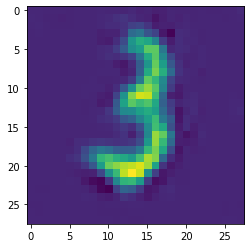

epoch: 1, step: 0, loss: 0.016982829198241234
epoch: 1, step: 200, loss: 0.014161674305796623


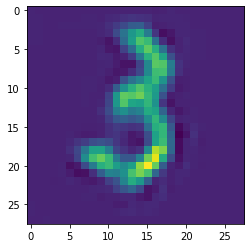

epoch: 2, step: 0, loss: 0.013928846456110477
epoch: 2, step: 200, loss: 0.013169444166123867


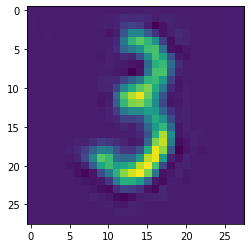

epoch: 3, step: 0, loss: 0.01295851543545723
epoch: 3, step: 200, loss: 0.011719200760126114


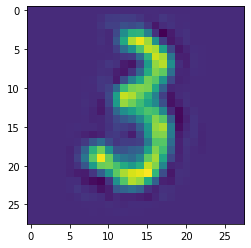

epoch: 4, step: 0, loss: 0.012184854596853256
epoch: 4, step: 200, loss: 0.01175859197974205


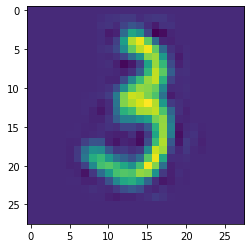

epoch: 5, step: 0, loss: 0.011625194922089577
epoch: 5, step: 200, loss: 0.011137697845697403


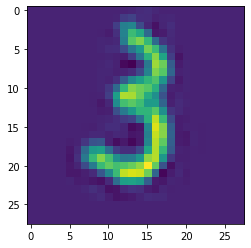

epoch: 6, step: 0, loss: 0.011476041749119759
epoch: 6, step: 200, loss: 0.01035926304757595


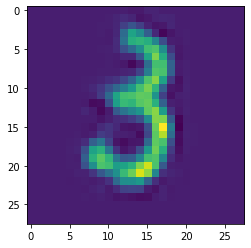

epoch: 7, step: 0, loss: 0.01070437952876091
epoch: 7, step: 200, loss: 0.010949024930596352


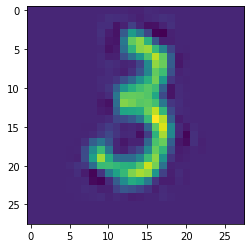

epoch: 8, step: 0, loss: 0.010614320635795593
epoch: 8, step: 200, loss: 0.010244131088256836


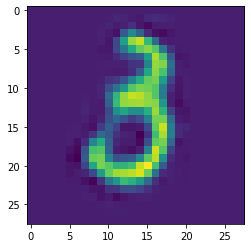

epoch: 9, step: 0, loss: 0.010461831465363503
epoch: 9, step: 200, loss: 0.010258576832711697


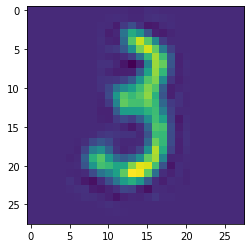

In [ ]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model_conv(batch['data'].to(device))
    loss = loss_func(predict, batch['data'].to(device))
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).unsqueeze(0).float()/255
  plt.imshow(model_conv(item.to(device)).squeeze().cpu().detach().numpy())
  plt.show()
  torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')

2.	Обучить VAE собственной архитектуры на MNIST

In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #делаем hidden_ch меньше(32 вместо 64), добавляем еще один слой
    self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(2, 2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1) # еще один слой
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2) # 7 x 7
    self.do3 = nn.Dropout(0.1)
    self.conv_mu = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.conv_sigma = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do2(self.conv2(self.do1(self.activ(self.pool1(self.conv1(x))))))
    x = self.do3(self.activ(self.pool2(self.conv3(x))))
    mu = self.conv_mu(x)
    sigma = torch.exp(self.conv_sigma(x))

    return mu, sigma

    

class Decoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(out_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)# еще один слой
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    self.do3 = nn.Dropout(0.1)
    self.conv4 = nn.Conv2d(hidden_ch, in_chan, kernel_size=3, stride=1, padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do2(self.conv2(self.do1(self.activ(self.upsample1(self.conv1(x))))))
    x = self.do3(self.activ(self.upsample2(self.conv3(x))))
    x = self.conv4(x)

    return x

def sampling(mu, sigma):
  norm = torch.normal(torch.zeros_like(mu), torch.ones_like(mu))
  return mu + sigma * norm

class ConvVarAutoEncoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.encoder = Encoder(in_chan, hidden_ch, out_ch)
    self.decoder = Decoder(in_chan, hidden_ch, out_ch)

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)

    return x_, mu, sigma

In [ ]:
def collate_fn_conv(data: list):
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [ ]:
model_conv = ConvVarAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.MSELoss()

def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))

    return torch.distributions.kl_divergence(p, q).mean()

epoch: 0, step: 0, loss: 0.10077042877674103
epoch: 0, step: 200, loss: 0.032806720584630966


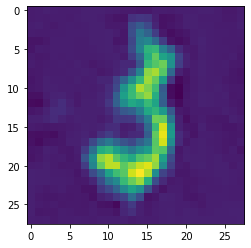

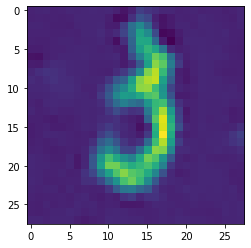

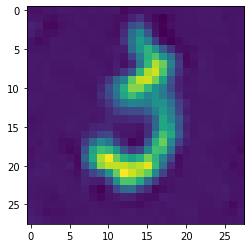

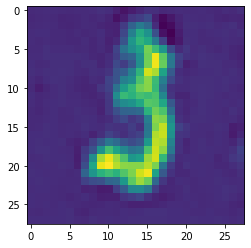

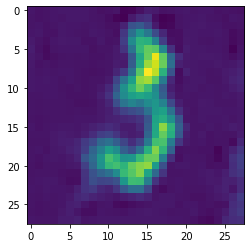

epoch: 1, step: 0, loss: 0.0320417620241642
epoch: 1, step: 200, loss: 0.029822317883372307


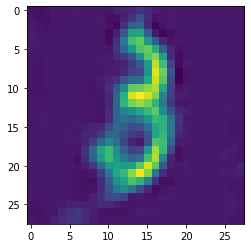

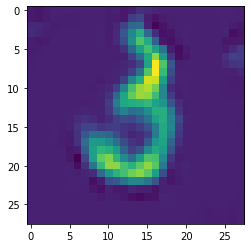

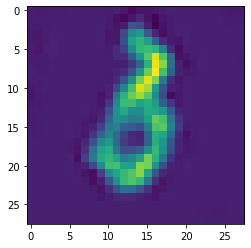

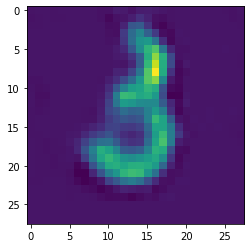

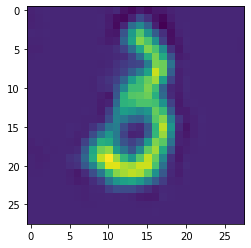

epoch: 2, step: 0, loss: 0.02843901515007019
epoch: 2, step: 200, loss: 0.028918474912643433


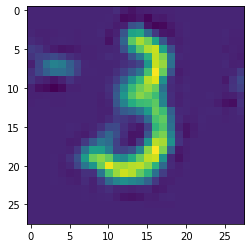

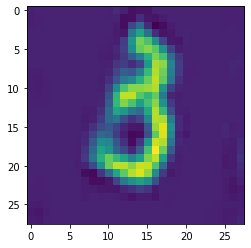

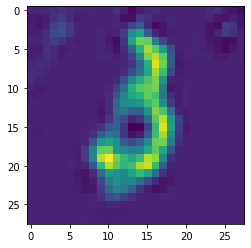

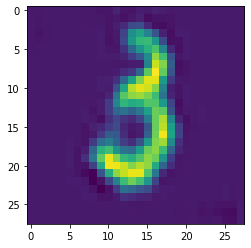

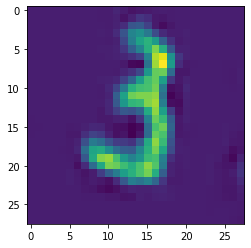

epoch: 3, step: 0, loss: 0.028128910809755325
epoch: 3, step: 200, loss: 0.027247630059719086


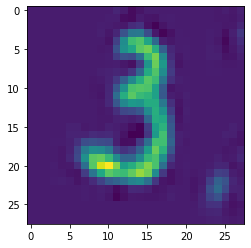

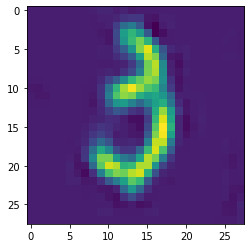

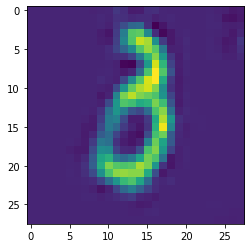

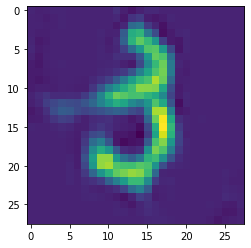

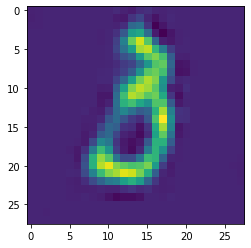

epoch: 4, step: 0, loss: 0.02690630964934826
epoch: 4, step: 200, loss: 0.026421483606100082


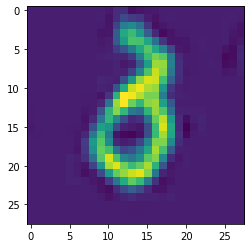

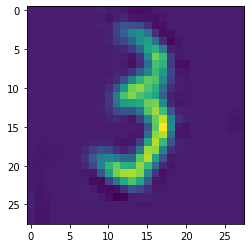

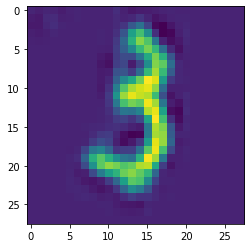

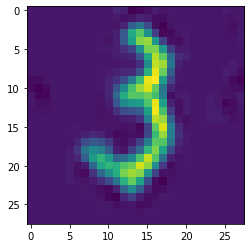

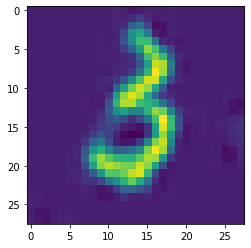

epoch: 5, step: 0, loss: 0.02724185585975647
epoch: 5, step: 200, loss: 0.02667907439172268


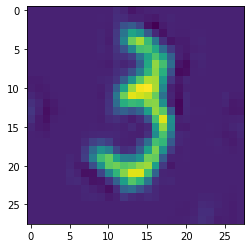

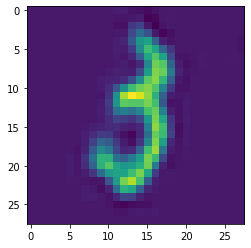

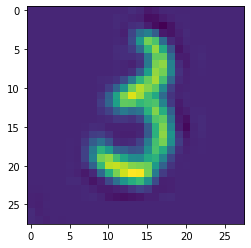

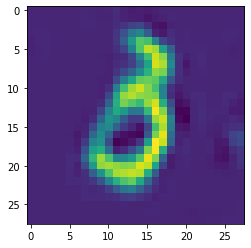

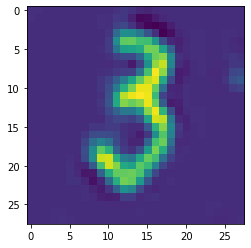

epoch: 6, step: 0, loss: 0.02653314545750618
epoch: 6, step: 200, loss: 0.025745101273059845


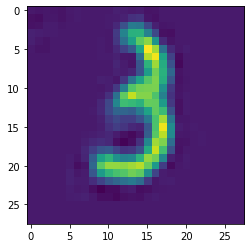

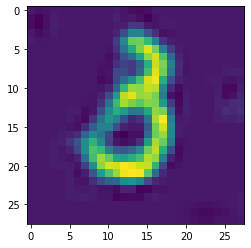

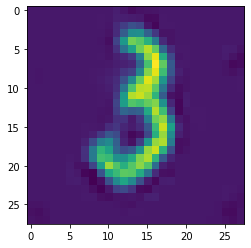

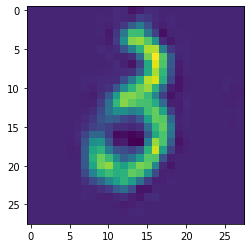

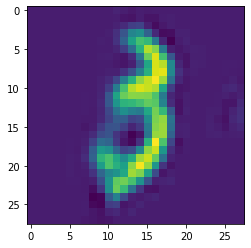

epoch: 7, step: 0, loss: 0.02641468495130539
epoch: 7, step: 200, loss: 0.026071473956108093


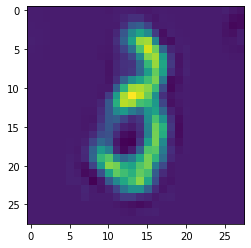

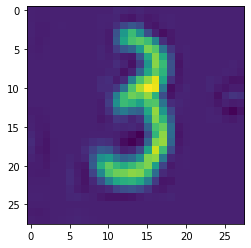

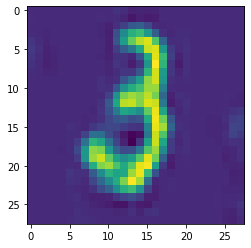

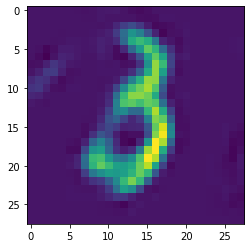

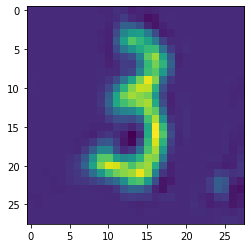

epoch: 8, step: 0, loss: 0.025221627205610275
epoch: 8, step: 200, loss: 0.026247534900903702


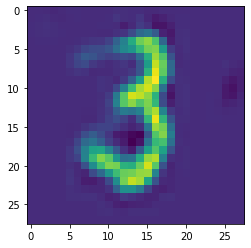

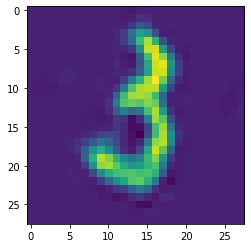

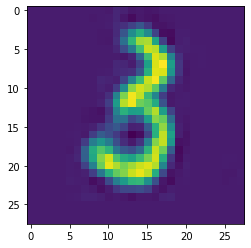

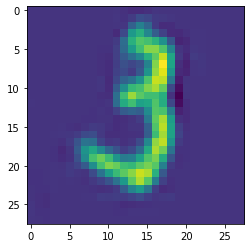

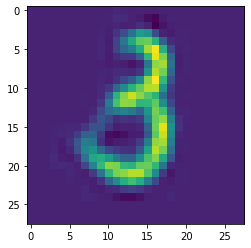

epoch: 9, step: 0, loss: 0.025669217109680176
epoch: 9, step: 200, loss: 0.02483522705733776


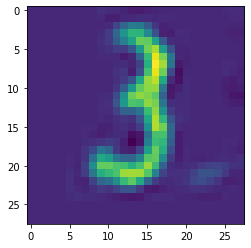

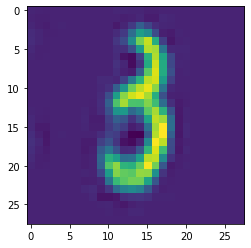

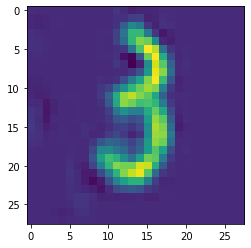

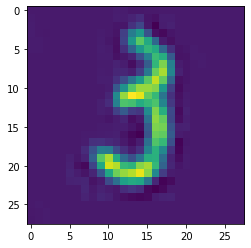

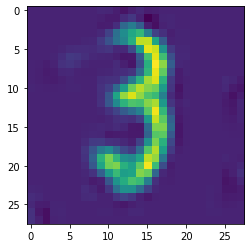

In [ ]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()
    data = batch['data'].to(device)
    predict, mu, sigma = model_conv(data)
    loss = loss_func(predict, data) + 0.01 * kl_loss(mu, sigma)
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).unsqueeze(0).float()/255
  mu, sigma = model_conv.encoder(item.to(device))
  for i in range(5):
    plt.imshow(model_conv.decoder(sampling(mu, sigma))[0].squeeze().cpu().detach().numpy())
    plt.show()
  torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')